# Generate Weak Localization Masks

This notebook generates segmentation masks from bounding box annotations in TBX11K dataset.

## Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Set Up Project Imports

In [2]:
import sys
from pathlib import Path

# Add your project to Python path
project_path = Path('/content/drive/MyDrive/TB_Segementation/tb-segmentation')
sys.path.insert(0, str(project_path))

# Verify path exists
print(f"Project path: {project_path}")
print(f"Path exists: {project_path.exists()}")
print(f"src/data exists: {(project_path / 'src' / 'data').exists()}")

Project path: /content/drive/MyDrive/TB_Segementation/tb-segmentation
Path exists: True
src/data exists: True


## Step 3: Import Functions

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import logging

# Set matplotlib to inline mode for Colab
%matplotlib inline

# Import weak localization functions
from src.data.weak_localization import (
    generate_mask_for_image,
    generate_masks_for_dataset,
    visualize_mask_overlay,
    parse_bbox_string,
    load_mask
)

# Set up logging
logging.basicConfig(level=logging.INFO)

print("All imports successful!")

All imports successful!


## Step 4: Set Up Data Paths

In [4]:
# Set up paths to your data
DATA_ROOT = Path('/content/drive/MyDrive/TB_Segmentation_Data')
TBX11K_PATH = DATA_ROOT / 'tbx11k'

csv_path = TBX11K_PATH / 'tbx11k-simplified' / 'data.csv'
images_dir = TBX11K_PATH / 'tbx11k-simplified' / 'images'
output_dir = TBX11K_PATH / 'tbx11k-simplified' / 'weak_masks'

print(f"CSV path: {csv_path}")
print(f"Images dir: {images_dir}")
print(f"Output dir: {output_dir}")

# Verify paths exist
print(f"\nCSV exists: {csv_path.exists()}")
print(f"Images dir exists: {images_dir.exists()}")

CSV path: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/data.csv
Images dir: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/images
Output dir: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/weak_masks

CSV exists: True
Images dir exists: True


## Step 5: Test on a Single Image

Total rows in CSV: 8811
Rows with bbox: 1211

Testing with image: tb0005.png


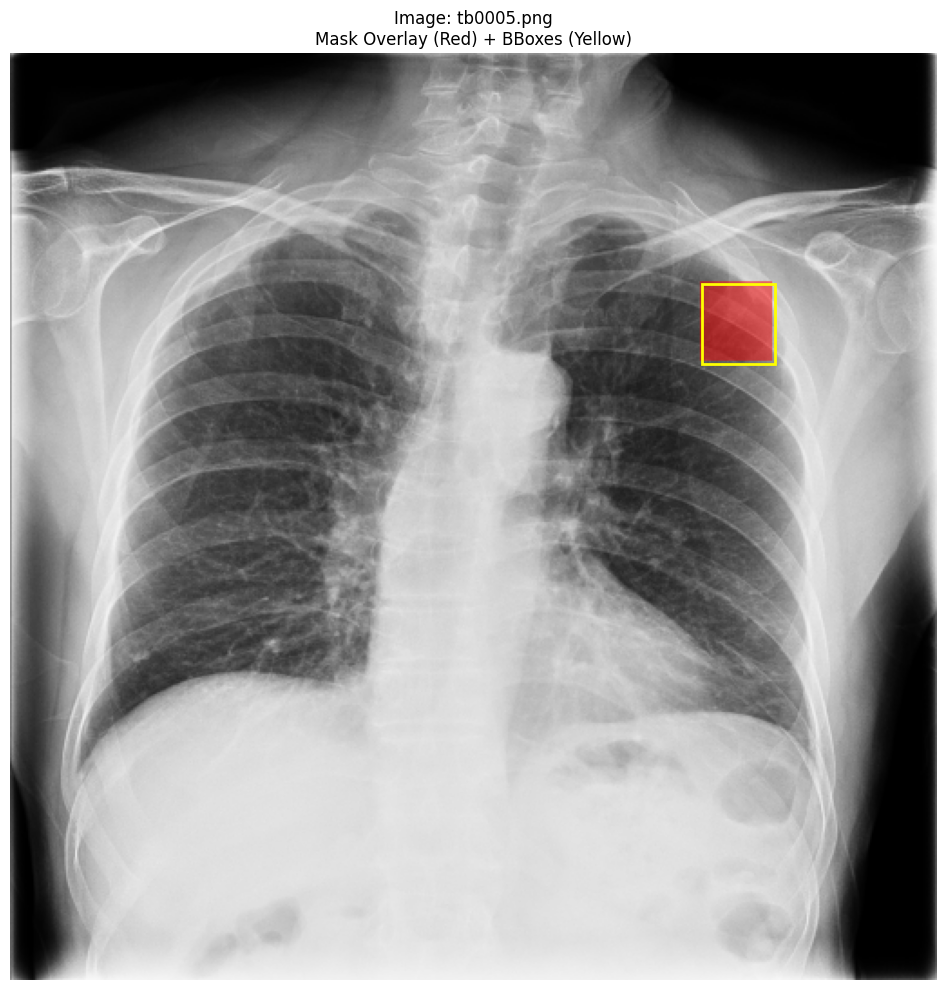

  Mask generated!
  Mask shape: (512, 512)
  TB pixels: 1760 / 262144


In [5]:
# Load CSV
df = pd.read_csv(csv_path)
print(f"Total rows in CSV: {len(df)}")

# Get image with bounding box
rows_with_bbox = df[df['bbox'] != 'none']
print(f"Rows with bbox: {len(rows_with_bbox)}")

if len(rows_with_bbox) > 0:
    # Get first image with bbox
    sample_row = rows_with_bbox.iloc[0]
    print(f"\nTesting with image: {sample_row['fname']}")

    # Generate mask
    image_path = images_dir / sample_row['fname']
    mask = generate_mask_for_image(image_path, [sample_row['bbox']])

    # Visualize
    bbox_dict = parse_bbox_string(sample_row['bbox'])
    visualize_mask_overlay(image_path, mask, bboxes=[bbox_dict] if bbox_dict else None)

    print(f"  Mask generated!")
    print(f"  Mask shape: {mask.shape}")
    print(f"  TB pixels: {mask.sum()} / {mask.size}")
else:
    print("No images with bounding boxes found!")

## Step 6: Generate Masks for All Images



In [6]:
# Generate all masks
stats = generate_masks_for_dataset(
    csv_path=csv_path,
    images_dir=images_dir,
    output_dir=output_dir
)

print("\n" + "="*60)
print("GENERATION COMPLETE!")
print("="*60)
print(f"Total images processed: {stats['total_images']}")
print(f"Masks generated: {stats['masks_generated']}")
print(f"Images with bbox: {stats['images_with_bbox']}")
print(f"Images without bbox: {stats['images_without_bbox']}")
print(f"Errors: {stats['errors']}")
print("="*60)

Generating masks: 100%|██████████| 8399/8399 [1:01:46<00:00,  2.27it/s]


GENERATION COMPLETE!
Total images processed: 8399
Masks generated: 8399
Images with bbox: 799
Images without bbox: 7600
Errors: 0


## Step 7: Verify Results

Total mask files generated: 8399
Images with bounding boxes in CSV: 1211

Sample mask shape: (512, 512)
Sample mask dtype: uint8
Mask has TB pixels: 1760 / 262144
  Masks generated successfully!

Visualizing: tb0005
Image path: /content/drive/MyDrive/TB_Segmentation_Data/tbx11k/tbx11k-simplified/images/tb0005.png
Bounding boxes found: 1


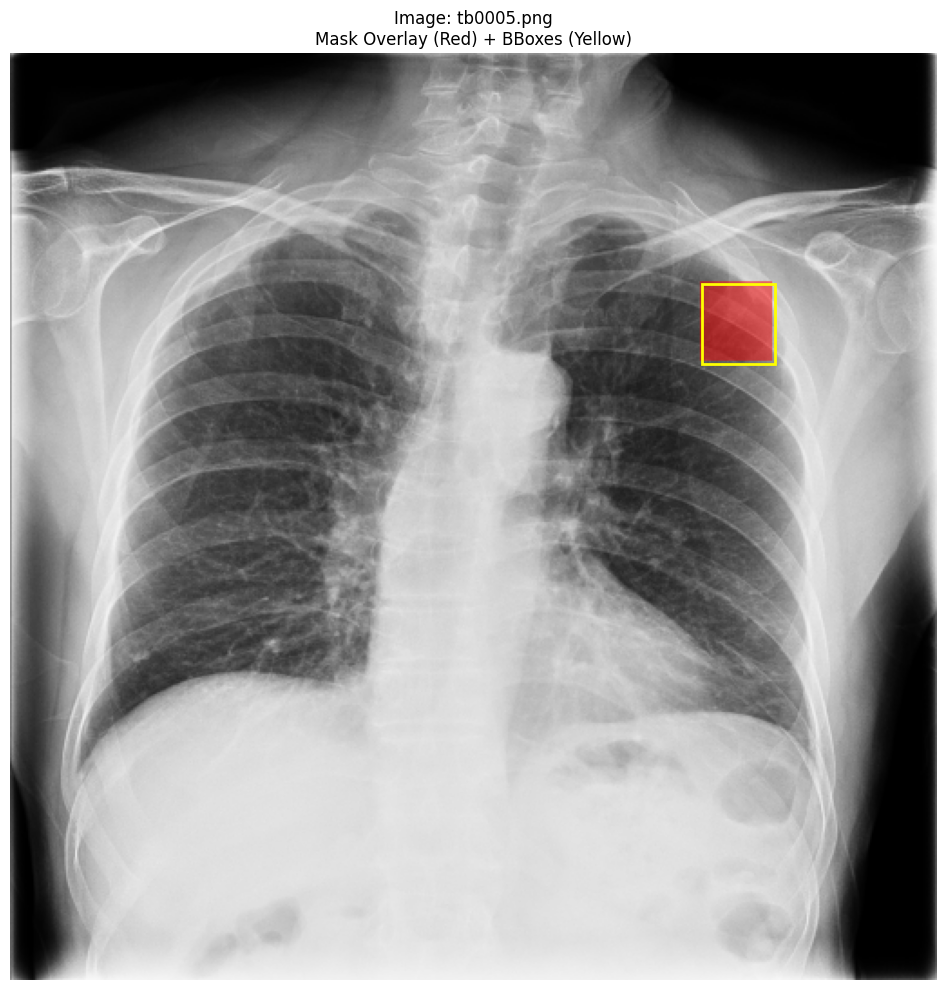

✓ Visualized: tb0005
  Found 1 bounding box(es) for this image


In [8]:
# Check output
mask_files = list(output_dir.glob('*.npy'))
print(f"Total mask files generated: {len(mask_files)}")

# Reload CSV if df is not available
if 'df' not in globals():
    df = pd.read_csv(csv_path)

# Find an image that has bounding boxes for visualization
rows_with_bbox = df[df['bbox'] != 'none']
print(f"Images with bounding boxes in CSV: {len(rows_with_bbox)}")

if len(mask_files) > 0 and len(rows_with_bbox) > 0:
    # Find a mask file that corresponds to an image with bounding boxes
    found_mask = None
    found_image_row = None

    for _, row in rows_with_bbox.iterrows():
        fname = row['fname']
        mask_name = Path(fname).stem
        mask_path = output_dir / f"{mask_name}.npy"

        if mask_path.exists():
            found_mask = mask_path
            found_image_row = row
            break

    if found_mask is None:
        print("No mask files found for images with bounding boxes!")
    else:
        # Load the mask
        sample_mask = load_mask(found_mask)
        mask_name = found_mask.stem
        image_path = images_dir / found_image_row['fname']

        print(f"\nSample mask shape: {sample_mask.shape}")
        print(f"Sample mask dtype: {sample_mask.dtype}")
        print(f"Mask has TB pixels: {sample_mask.sum()} / {sample_mask.size}")
        print(f"  Masks generated successfully!")

        if image_path.exists():
            # Parse bounding boxes for this image
            mask_fname = found_image_row['fname']
            image_rows = df[df['fname'] == mask_fname]

            bboxes_list = []
            for idx, row in image_rows.iterrows():
                if row['bbox'] != 'none' and not pd.isna(row['bbox']):
                    bbox_dict = parse_bbox_string(row['bbox'])
                    if bbox_dict:
                        bboxes_list.append(bbox_dict)

            # Visualize with bounding boxes
            print(f"\nVisualizing: {mask_name}")
            print(f"Image path: {image_path}")
            print(f"Bounding boxes found: {len(bboxes_list)}")

            visualize_mask_overlay(image_path, sample_mask, bboxes=bboxes_list if bboxes_list else None)

            print(f"✓ Visualized: {mask_name}")
            if bboxes_list:
                print(f"  Found {len(bboxes_list)} bounding box(es) for this image")
        else:
            print(f"Image not found: {image_path}")
else:
    print("No mask files or images with bounding boxes found!")